## Alternate Architectures Tested

### LSTM

    Different from the one we use as main method, this model is a pure LSTM model with two linear fully connected layer. Its architecture is simple, and we first apply principle components analysis for data compression since the original dimension of the image is too larges and cost too much memory and time during training computation.
    
    The reason why we try to use LSTM is that LSTM well-suited to processing and making predictions based on time series data which is exactly our objectives in this question scenario. As well, the ability to deal with the vanishing gradient problem and relative insensitivity to gap length is a advantage of LSTM.
    
    The result and codes of our lstm model is shown below for reference.

![](https://raw.githubusercontent.com/edsml-jj621/for_markdown/main/result_lstm.jpg)

    pred1 ssim: 0.48395 mse:  414.40414
    pred2 ssim: 0.33777 mse:  1160.74792
    pred3 ssim: 0.32057 mse:  1426.03576
    pred4 ssim: 0.30992 mse:  1648.07779
    pred5 ssim: 0.29289 mse:  1877.05263

    The result of other storm

![](https://raw.githubusercontent.com/edsml-jj621/for_markdown/main/result_lstm2.jpg)

### Convolutional Autoencoder

    The architectures of this CAE is simple, it first uses PCA for data compression, and applied 2 convolutional layers and 1 linear layer in encoder part and the same inverse 3 in decoder part.
    
    As for the input and output, assuming we have 101 images, we select the first 1-100 images as the input sample, and select the 2-101 images as the output target. It means after training, our model should be able to predict the next image given the previous one. As a result, the limitation of our this CAE model is obvious, it can only predict the next frame.
    
    The result and codes of our model is shown below.

![](https://raw.githubusercontent.com/edsml-jj621/for_markdown/main/result_cae.jpg)

    pred1 ssim: 0.27222 mse:  3430.71933
    pred2 ssim: 0.30511 mse:  2038.87866
    pred3 ssim: 0.33928 mse:  2819.54282
    pred4 ssim: 0.35241 mse:  1576.36546
    pred5 ssim: 0.35631 mse:  2337.50091

### Code for Reference (CAE)

In [ ]:
# load the train data (sample and target)
set_seed(42)
jpg_names = sorted(glob('nasa_tropical_storm_competition_train_source_acd/**/*.jpg'))
X_raw = np.zeros((100, 366, 366))
y_raw = np.zeros((100, 366, 366))
for i in range(100):
    X_raw[i] = imread(jpg_names[i])
    y_raw[i] = imread(jpg_names[i+1])

# minmax scale
X_n = (X_raw - X_raw.min()) / (X_raw.max() - X_raw.min())
y_n = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

# use PCA to compress the data
from sklearn.decomposition import PCA
pca = PCA(100)
X_pca = pca.fit_transform(X_n.reshape(100, 366*366)).reshape(100, 1, 10, 10)
y_pca = pca.fit_transform(y_n.reshape(100, 366*366)).reshape(100, 1, 10, 10)
X_train = torch.from_numpy(X_pca).float()
y_train = torch.from_numpy(y_pca).float()

In [ ]:
# define the model
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = nn.Conv2d(1, 16, kernel_size=3, padding='same')
        self.c2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        # self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.l3 = nn.Linear(3200, 200)
        self.l4 = nn.Linear(200, 3200)
        # self.s5 = nn.Upsample(scale_factor=2)
        self.c5 = nn.ConvTranspose2d(32, 16, kernel_size=1)
        self.output = nn.ConvTranspose2d(16, 1, kernel_size=1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.c2(x))
        x = x.view(-1, 32*10*10)
        x = self.act(self.l3(x))
        x = self.act(self.l4(x))
        x = x.view(-1, 32, 10, 10)
        x = self.act(self.c5(x))
        return self.output(x)
    
model = LeNet5()
summary(model, input_size=(1, 10, 10))

In [ ]:
# train the model
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 10, 10))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset)

In [ ]:
# start training
m_train = TensorDataset(X_train, y_train)
model = LeNet5().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
train_loader = DataLoader(m_train, batch_size=10)
for epoch in range(200):
    train_loss = train(model, optimizer, criterion, train_loader)
    if epoch % 20 == 0:
        print(train_loss)

In [ ]:
# prediction and plot
dataset1 = np.zeros((5,366,366))
dataset2 = np.zeros((5,366,366))
y_pred1 = model(y_train[-1].view(1, 1, 10, 10))
y_pred1_np = y_pred1.detach().numpy()
dataset1[0] = pca.inverse_transform(y_pred1_np.reshape(1, 100)).reshape(366, 366)
y_pred2 = model(y_pred1.view(1, 1, 10, 10))
y_pred2_np = y_pred2.detach().numpy()
dataset1[1] = pca.inverse_transform(y_pred2_np.reshape(1, 100)).reshape(366, 366)
y_pred3 = model(y_pred2.view(1, 1, 10, 10))
y_pred3_np = y_pred3.detach().numpy()
dataset1[2] = pca.inverse_transform(y_pred3_np.reshape(1, 100)).reshape(366, 366)
y_pred4 = model(y_pred3.view(1, 1, 10, 10))
y_pred4_np = y_pred4.detach().numpy()
dataset1[3] = pca.inverse_transform(y_pred4_np.reshape(1, 100)).reshape(366, 366)
y_pred5 = model(y_pred4.view(1, 1, 10, 10))
y_pred5_np = y_pred5.detach().numpy()
dataset1[4] = pca.inverse_transform(y_pred5_np.reshape(1, 100)).reshape(366, 366)

In [ ]:
def visual_data(dataset):
    fig, axes = plt.subplots(1, 5, figsize=[20, 3])
    ts = [0, 1, 2, 3, 4]
    for i, ax in enumerate(axes.ravel()):
        im = ax.imshow(dataset.reshape(5, 366, 366)[ts[i]], cmap='gray')
        ax.set_title(str(ts[i]+101))
        # fig.colorbar(im, ax=ax)
        
dataset2[0] = imread(jpg_names[101])
dataset2[1] = imread(jpg_names[102])
dataset2[2] = imread(jpg_names[103])
dataset2[3] = imread(jpg_names[104])
dataset2[4] = imread(jpg_names[105])
visual_data(dataset1)
visual_data(dataset2)

In [ ]:
# compute the ssim and mse
def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

for i in range(5):
    target = imread(jpg_names[101+i])
    predic = dataset1[i]
    predic = scale2range(predic, [target.min(), target.max()])
    target, predic = target.astype(np.uint8), predic.astype(np.uint8)
    s, m = ssim(target, predic), mse(target, predic)
    print('ssim: %.5f' %s, 'mse:  %.5f' %m)
    print()

### Code for Reference (LSTM)

In [ ]:
# your imports and initial checks here
# !pip install pycm livelossplot
# %pylab inline
from pycm import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models
from torchsummary import summary
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
from glob import glob
import tarfile
from pathlib import Path
from matplotlib.image import imread
from sklearn.decomposition import PCA

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False
    return True

device = 'cpu'

In [74]:
# laod data
set_seed(42)
# load the jpg names
jpg_names = sorted(glob('nasa_tropical_storm_competition_surprise_storm_source/**/*.jpg'))
X_raw = np.zeros((95, 366, 366))
# let the training set to be first 95 images
for i in range(95):
    X_raw[i] = imread(jpg_names[i])
# minmax scaling
X_n = (X_raw - X_raw.min()) / (X_raw.max() - X_raw.min())
pca = PCA(95)
# define the PCA for data compression
# do the data compression 
X_pca = pca.fit_transform(X_n.reshape(95, 366*366)).reshape(95, 95)
X_train = X_pca.reshape(95, 19, 5)

In [75]:
# Hyper-parameters
sequence_length = 5
input_size = 19*5
hidden_size = 1024
num_layers = 3
num_feature = 19*5*5
batch_size = 5
num_epochs = 350
learning_rate = 0.0001

In [76]:
# for building the sample data and target to fit in Lstm model
class StormTensorDataset(TensorDataset):
    def __init__(self, data, transform=None, sequence_len=sequence_length):
        self.data = data
        self.transform = transform
        self.sequence_len = sequence_len
        
    def __len__(self):
        return len(self.data) - self.sequence_len

    def __getitem__(self, idx):
        # sample = mpimg.imread(self.data[idx])
        if self.transform:
            sample = torch.stack([self.transform(self.data[idx+i]) for i in range(self.sequence_len)])
            sample = torch.transpose(sample, 0, 1)
            target = torch.stack([self.transform(self.data[idx+i+1]) for i in range(self.sequence_len)])
            target = torch.transpose(target, 0, 1)
        return sample.float(), target.float()
# build the dataloader
transform = transforms.Compose([transforms.ToTensor()])
train_data = StormTensorDataset(X_train, transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [77]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_feature):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, 800)
        self.fc = nn.Linear(800, num_feature)
        # self.act = nn.ReLU()
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.linear(out[-1, :, :])
        out = self.fc(out)
        # out = self.fc(out[:, -1, :])
        out = out.reshape(-1, sequence_length, input_size)
        return out

In [79]:
model = RNN(input_size, hidden_size, num_layers, num_feature).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, target) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        target = target.reshape(-1, sequence_length, input_size).to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 18 == 0: # and (epoch+1) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [ ]:
for i in range(5):
    X_last = np.array(X_train[-5:].reshape(1, 5, 95))
    X_last = torch.tensor(X_last).float()
    model.eval()
    with torch.no_grad():
        pred_lat = model(X_last)
        pred_lat = pred_lat[-1][-1].reshape(1, input_size)
        pred_lat = pred_lat.detach().numpy().reshape(1, input_size)
        X_pca = np.append(X_pca, pred_lat, axis=0)
        X_train = X_pca.reshape(96+i, 95, 1) 
        # pred_phy = pca.inverse_transform(pred_lat)

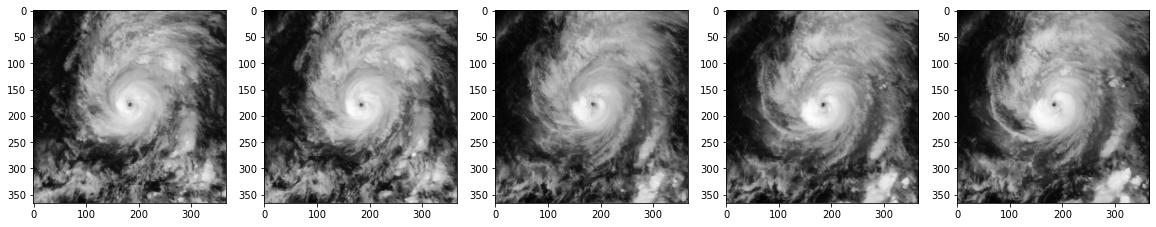

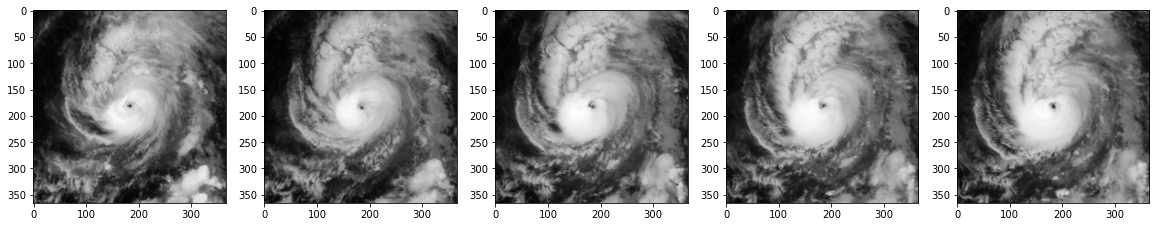

In [81]:
result = pca.inverse_transform(X_pca)[-5:].reshape(5, 366, 366)
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(result[i], cmap='gray')
    
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(imread(jpg_names[i+95]), cmap='gray')

In [1]:
def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

for i in range(5):
    # Load images and cast to np arrays, defining datatypes as floats for scale2range function
    target = imread(jpg_names[95+i])
    predic = result[i]
    # Scale predicted image to target range
    predic = scale2range(predic, [target.min(), target.max()])
    # Cast to uint8 to accommodate for consistent SSIM and MSE results
    target, predic = target.astype(np.uint8), predic.astype(np.uint8)
    # Sanity check
    # print(target.dtype, target.max(), target.min())
    # print(predic.dtype, predic.max(), predic.min())
    # Compute metrics
    s, m = ssim(target, predic), mse(target, predic)
    print('ssim: %.5f' %s, 'mse:  %.5f' %m)
    print()

In [72]:
torch.save(model, './lstm.pt')
model = torch.load('./lstm.pt')

## Hyperparameter tuning in ConvLSTM

- which hyperpameters were tested and what is the role of each one
- best hyperparameters and coresponding mse and ssim
- issues with cuda and what else could be tested

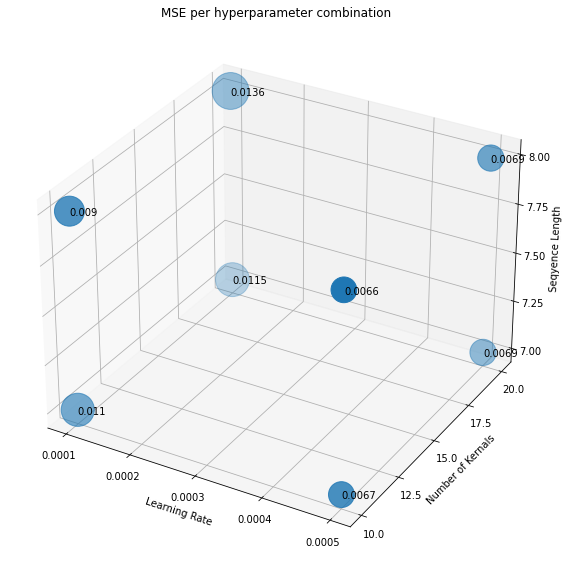

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(42)

lr = [1e-4, 1e-4, 1e-4, 1e-4,5e-4, 5e-4, 5e-4, 5e-4]

num_kernals =     [10,   10, 20, 20, 10,   10, 20, 20]

sequence_length = [7, 8, 7, 8, 7, 8, 7, 8]

mse = [0.0110, 0.009, 0.0115, 0.0136, 0.0067, 0.0066, 0.0069, 0.0069]

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lr, num_kernals, sequence_length, s= [i *100000 for i in mse],  cmap='copper')
plt.locator_params( nbins=5)

for x,y,z,i in zip(lr, num_kernals, sequence_length,mse):
    ax.text(x,y,z,i, verticalalignment='center_baseline' )

ax.set_xlabel("Learning Rate")
ax.set_ylabel("Number of Kernals")
ax.set_zlabel("Seqyence Length")
ax.set_title("MSE per hyperparameter combination")

plt.show()

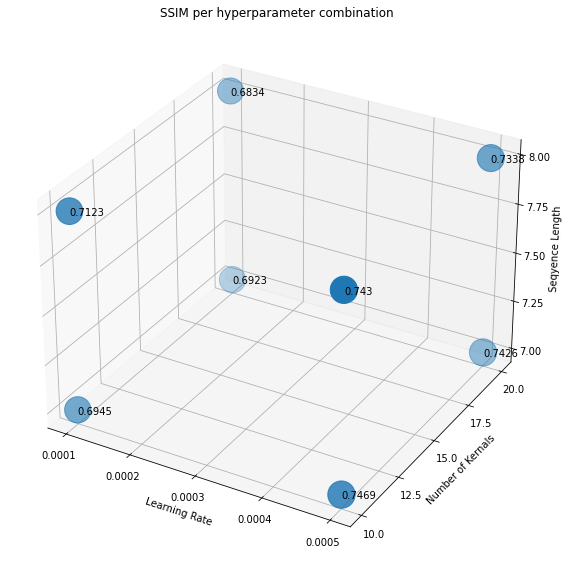

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(42)

lr = [1e-4, 1e-4, 1e-4, 1e-4,5e-4, 5e-4, 5e-4, 5e-4]

num_kernals =     [10,   10, 20, 20, 10,   10, 20, 20]

sequence_length = [7, 8, 7, 8, 7, 8, 7, 8]

ssim = [0.6945, 0.7123, 0.6923, 0.6834, 0.7469, 0.7430, 0.7426, 0.7338]

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lr, num_kernals, sequence_length, s= [i *1000 for i in ssim],  cmap='copper')
plt.locator_params( nbins=5)

for x,y,z,i in zip(lr, num_kernals, sequence_length,ssim):
    ax.text(x,y,z,i, verticalalignment='center_baseline' )

ax.set_xlabel("Learning Rate")
ax.set_ylabel("Number of Kernals")
ax.set_zlabel("Seqyence Length")
ax.set_title("SSIM per hyperparameter combination")

plt.show()


The convolutional LSTM provides stable training results (shown below), with convergence for most runs using 15 epochs - this supports our use for the convolutional LSTM, the stability and robustness of the losses during give credibility to its use. In general, we see high accuracy using MSE and SSIM measures with the convolutional LSTM, particularly for storms where we have large amounts of data such as FCR which gives and SSIM of 0.97.

As shown in the MSE and SSIM Plots above, there is an improvement in results by increasing the learning rate. However, increasing the learning rate too much results in instabilities, often outputting in nan values when training the model with high learning rates. It is likely that the loss function is highly choatic for a complex training task such as the one we are attempting. This unstable loss function results in errors when the learning rate is high, to mitigate this, we have a limited small range to work with for the learning rate, so that the parameter weightings dont change drastically and crash CUDA memory. While this is an issue for the model, it is not unique to the convolutional LSTM which is why we still support it as the main model to use.

For the hyperparameters number of kernels and sequence length, we dont see a noticable MSE/SSIM impact when adjusting these variables. This could be due to either choosing the parameters from small range, or insensitivity of the parameters to the particular training problem/dataset.

- Learning Rate - 1e-4
- Number of Kernals - 20
- Sequence Length - 7

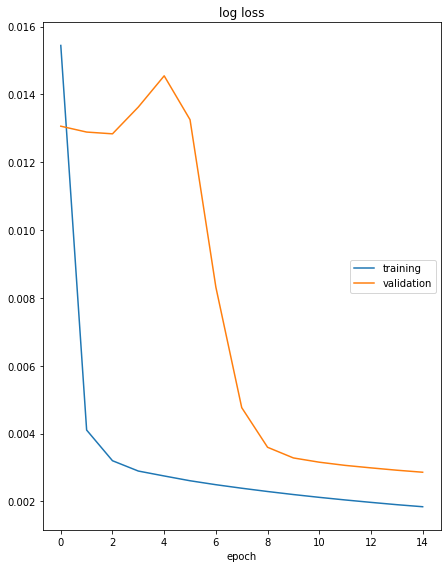

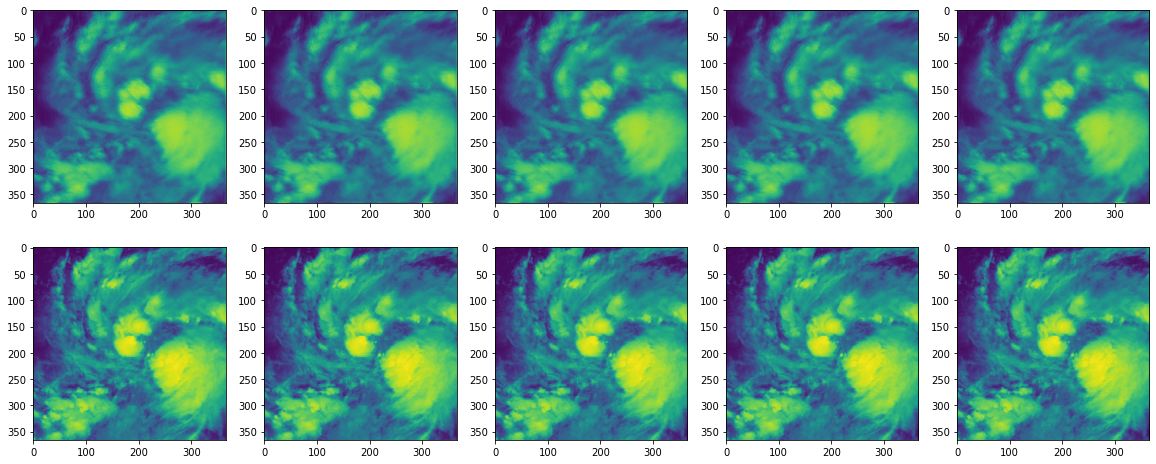

- Learning Rate - 1e-4
- Number of Kernals - 20
- Sequence Length - 8

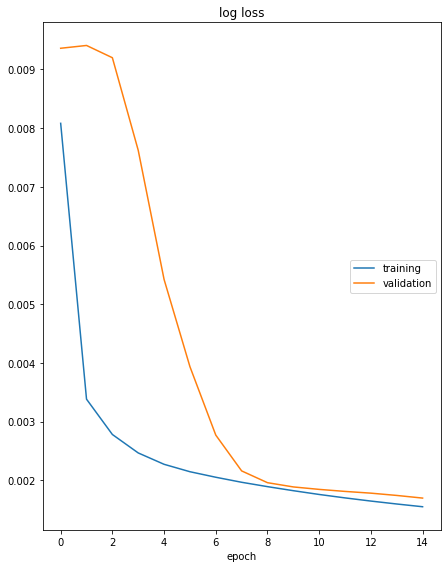


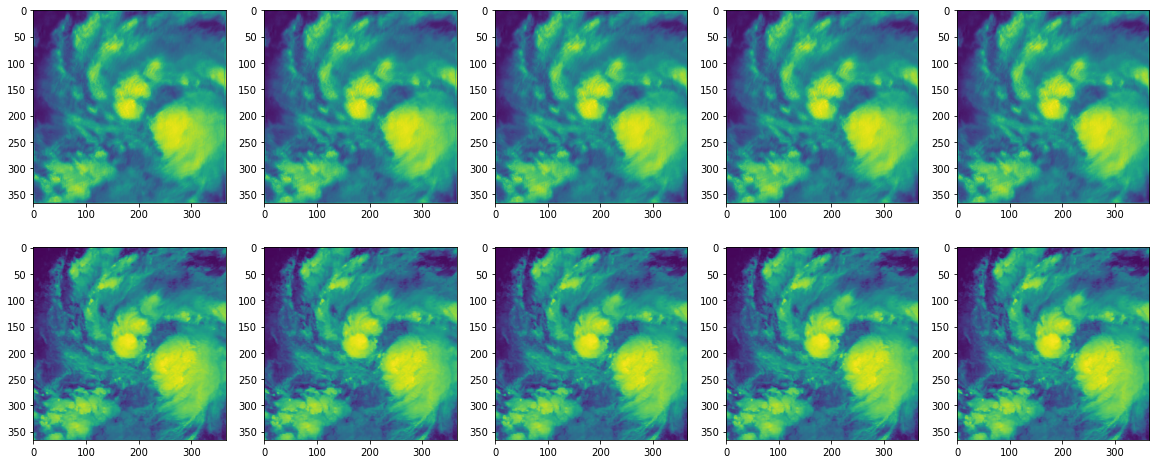

- Learning Rate - 1e-4
- Number of Kernals - 10
- Sequence Length - 7

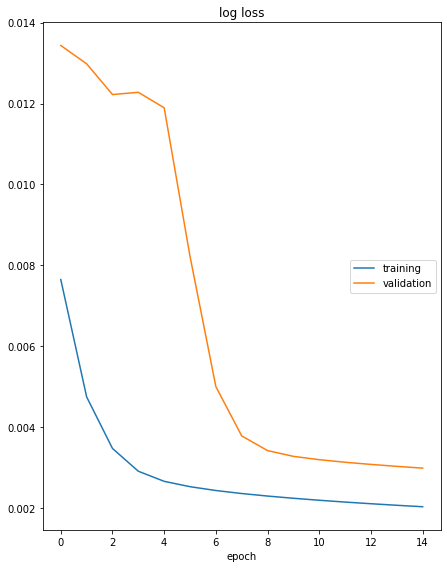


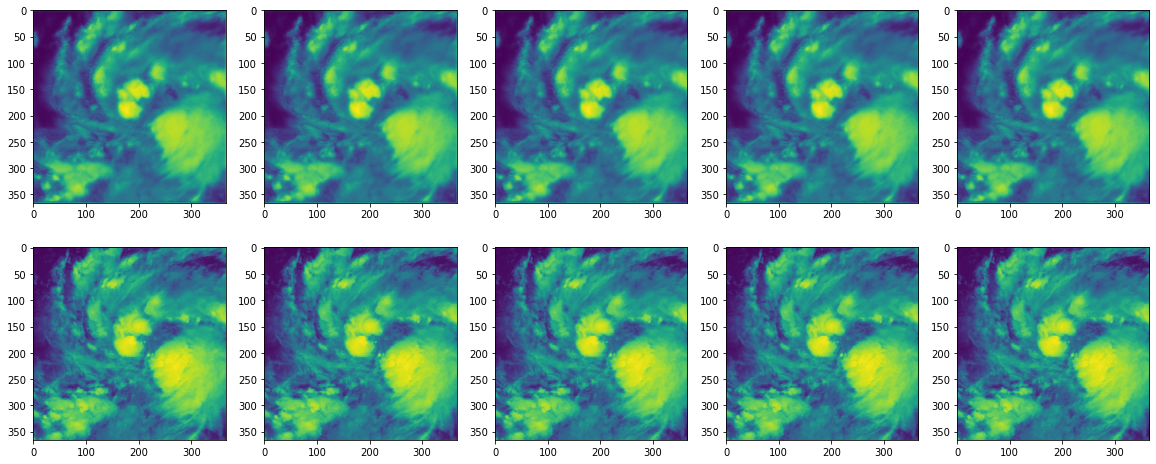

- Learning Rate - 1e-4
- Number of Kernals - 10
- Sequence Length - 8

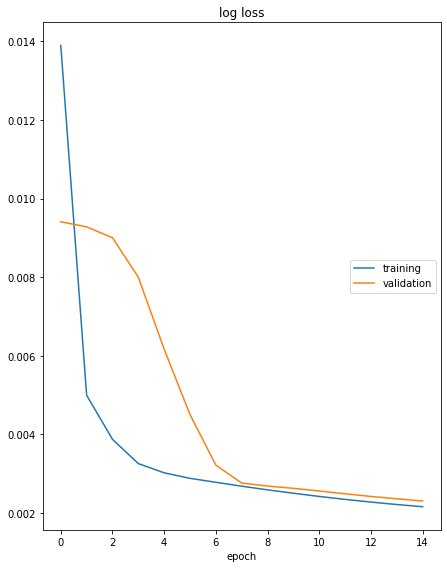


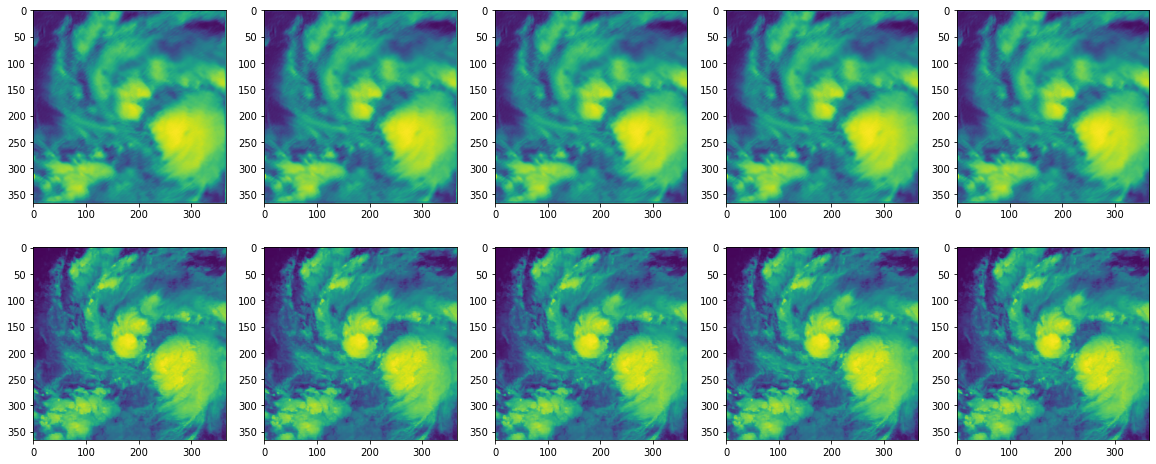

- Learning Rate - 5e-4
- Number of Kernals - 20
- Sequence Length - 7


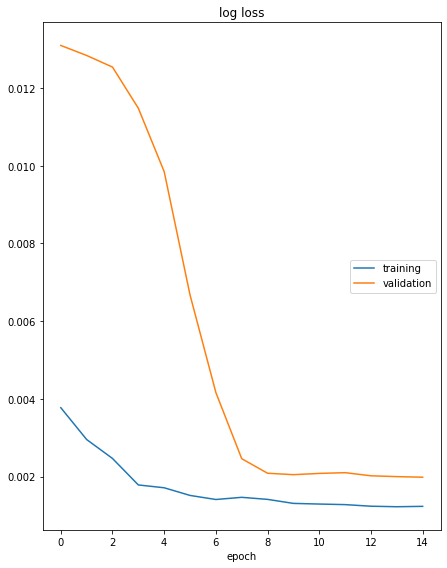

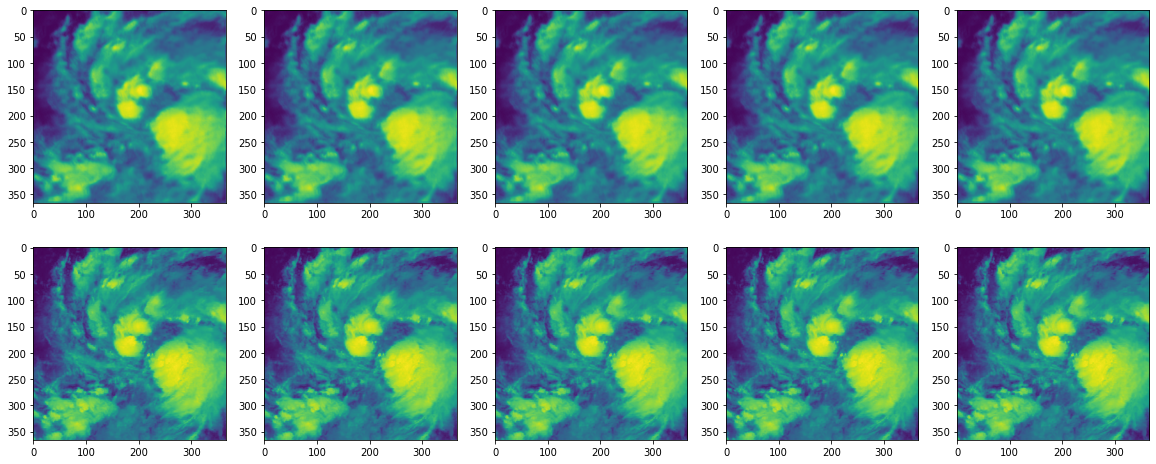

- Learning Rate - 5e-4
- Number of Kernals - 20
- Sequence Length - 8

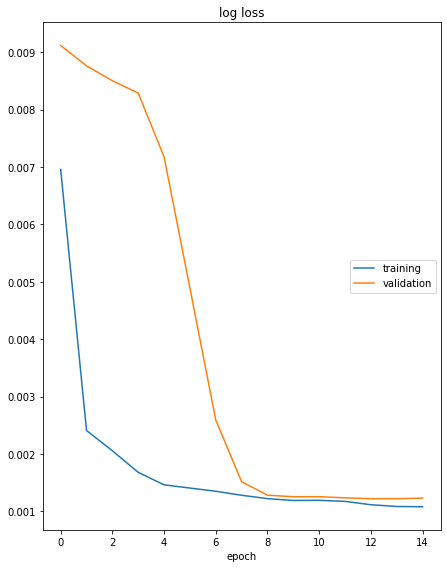

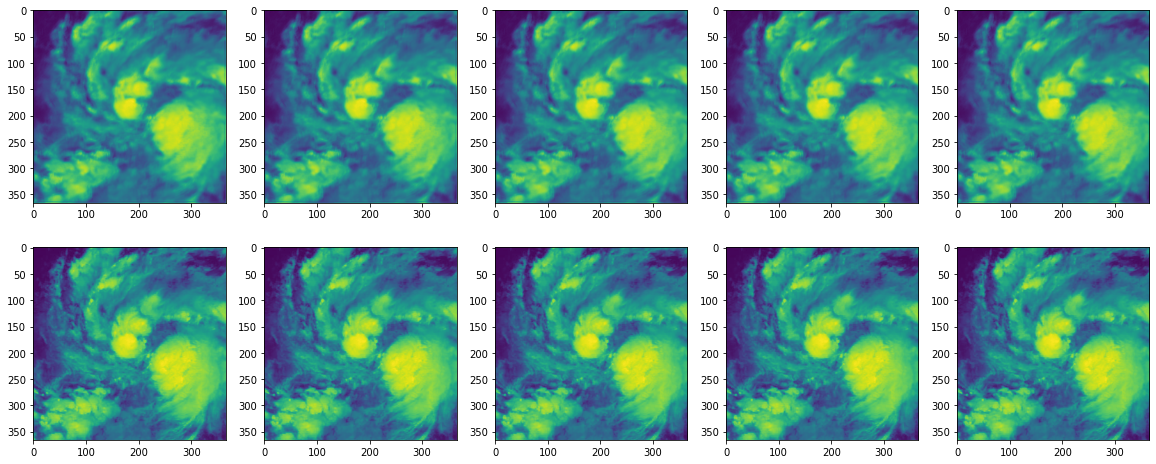

- Learning Rate - 5e-4
- Number of Kernals - 10
- Sequence Length - 7

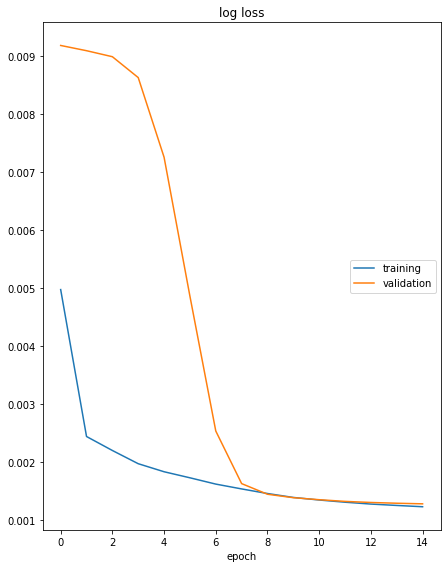


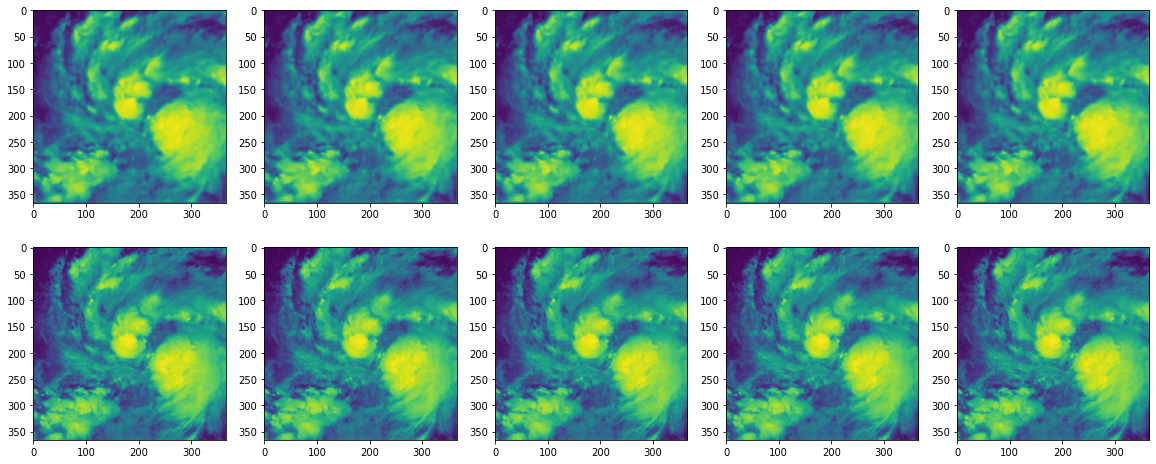

- Learning Rate - 5e-4
- Number of Kernals - 10
- Sequence Length - 8

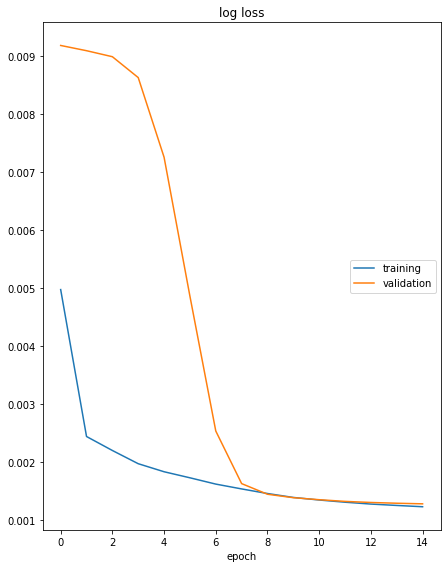

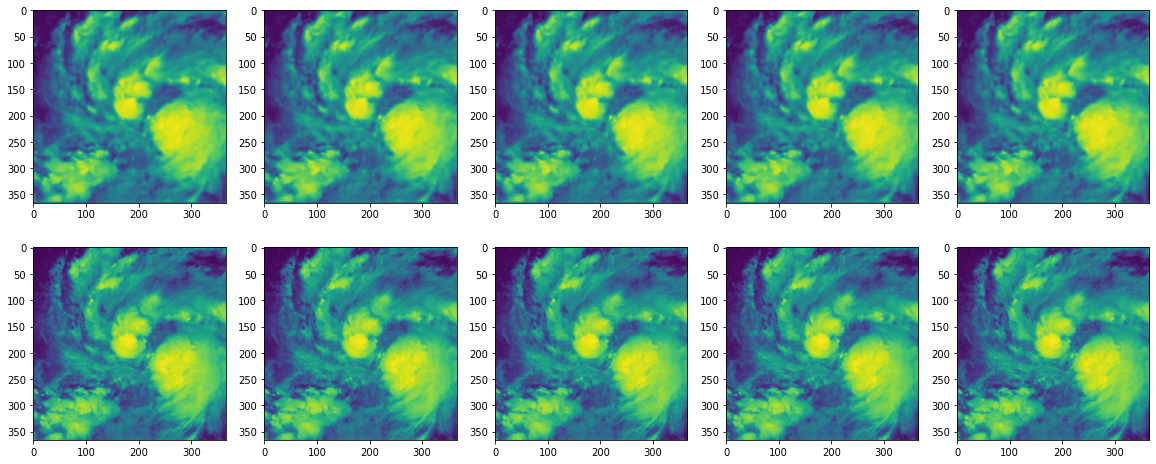